### More complex Torch -neural network example

**This version also uses Torch with GPU -support**

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# load the data
df = pd.read_csv("Salary_Data.csv")

# common in PyTorch codes, device variable
# that keeps track if using GPU or CPU
# NOTE: you need an NVIDIA GPU with CUDA -support for GPU support to work
# AMD has the corresponding ROCm, but it's not as good speed-wise and not as 
# widely supported by common neural network modules
# ROCm is typically/roughly 1.5x faster than plain CPU, while CUDA is often 5-10x faster than a CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# to override and just use CPU anyway:
# device = torch.device("cpu")

# print the selected device (note => CUDA => GPU)
print("Selected device for the model:")
print(device)

Selected device for the model:
cpu


In [23]:
# MAKE SURE DATA FORMATS ARE IDENTICAL

X = df['YearsExperience']
y = df['Salary']

# Prepare input + target tensors
inputs = torch.tensor(X.values, dtype=torch.float32).unsqueeze(1)
targets = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

print(inputs.shape)
print(targets.shape)

torch.Size([30, 1])
torch.Size([30, 1])


In [24]:
# our network dimensions/specifications
nInput  = 1
nHidden = 10
nOutput = 1

# define our network
class ANNRegression(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()

        # COMPARE THIS INTO TYPICAL KERAS REGRESSION NETWORK
        self.layers = nn.Sequential(
            nn.Linear(nInput, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

model = ANNRegression(nInput, nHidden, nOutput).to(device)

In [25]:
loss_list = []

# Training loop
def fit(num_epochs, model, loss_fn, optimizer, train_dataloader, val_dataloader):
    for epoch in range(num_epochs):
        epoch_losses = []

        # perform a training step
        model.train()
        for x, y in train_dataloader:

            # see how we use the device -object here
            # with this it's possibly to use same code for both CPU and GPU
            # without changes
            x, y = x.to(device), y.to(device)

            preds = model(x)
            loss = loss_fn(preds, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_losses.append(loss.item())

        avg_loss = sum(epoch_losses)/len(epoch_losses)
        loss_list.append(avg_loss)

        # Validation
        if (epoch + 1) % 50 == 0:
            model.eval()
            with torch.no_grad():
                val_losses = []
                for x_val, y_val in val_dataloader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    pred_val = model(x_val)
                    val_loss = loss_fn(pred_val, y_val)
                    val_losses.append(val_loss.item())

            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {avg_loss:.4f}, "
                  f"Val Loss: {np.mean(val_losses):.4f}")

In [26]:
# Define model training metadata.            
num_epochs = 500
# Dataloaders
dataset = TensorDataset(inputs, targets)
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1)

# Train
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

fit(num_epochs, model, loss_fn, optimizer, train_loader, val_loader)

Epoch [50/500], Train Loss: 64342165.6667, Val Loss: 32485628.0000
Epoch [100/500], Train Loss: 47048360.2493, Val Loss: 43157109.3333
Epoch [150/500], Train Loss: 34711253.4348, Val Loss: 56354262.0000
Epoch [200/500], Train Loss: 28687207.3469, Val Loss: 67609166.6667
Epoch [250/500], Train Loss: 26679349.3901, Val Loss: 75174116.0000
Epoch [300/500], Train Loss: 27347208.3222, Val Loss: 79154673.3333
Epoch [350/500], Train Loss: 26112539.9258, Val Loss: 80943062.6667
Epoch [400/500], Train Loss: 26670974.1496, Val Loss: 81745189.3333
Epoch [450/500], Train Loss: 26473693.9337, Val Loss: 82085089.3333
Epoch [500/500], Train Loss: 26403344.5931, Val Loss: 82561370.6667


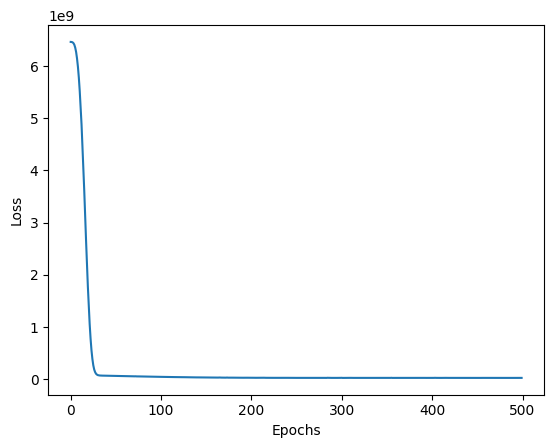

In [27]:
# We can plot the loss function and see how it changes with epochs. 
# The trend is that it should move downwwards and the loss should decrease
plt.plot(range(num_epochs),loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Try model in practice**

In [28]:
years = 7

testing = torch.tensor([[years]], dtype=torch.float32).to(device)

# switch the model into evaluation mode before using in practice (inference)
model.eval()
with torch.no_grad():
    pred = model(testing).cpu().numpy()
    result = pred[0][0]
    result = round(float(result), 2)
    print(f"Predicted salary for {years} years experience: {result} $")

Predicted salary for 7 years experience: 91375.53 $
